## Paper 2 Data Workflow for Data Extraction - CUADv1 - Prepare Dataset

In [1]:
import re, json, os, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en import English
from spacy.training import offsets_to_biluo_tags # requires spaCy 3.0

In [2]:
# download transformer model for spaCy if required
# !python -m spacy download en_core_web_md

In [3]:
!python -m spacy validate # Ensure minimum v3.0.0

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.6) =================
ℹ spaCy installation:
/home/phil/anaconda3/envs/p2d/lib/python3.8/site-packages/spacy

NAME             SPACY            VERSION                            
en_core_web_md   >=3.0.0,<3.1.0   3.0.0   ✔



### 1. File handling - CUADv1

In [4]:
MASTER_PATH = "../CUAD-v1/"
JSONL_FILE = 'project_6_dataset.jsonl'
JSONL_FILE_INS = 'project_7_dataset.jsonl'
FEATURE_CLASS_LABELS = "feature_class_labels.json"
DATA_FILE = 'cuad-v1-annotated.json'

### 2. Text Data Preprocessing - CUADv1 - Continued

#### Using Doccano to tag the text file dataset:
 - Install doccano at the command line: pip install doccano
 - At the command line change the directory to this directory
 - run doccano at the command line by typing 'doccano'
 - Application will be running at http://0.0.0.0:8000/
 - Username is 'admin', passowrd is 'password'
 - Use ctrl-c to end application

#### Prepare updated dataset for fine-tuning Transformers with HuggingFace

In [5]:
# JSONL is a multi-line json file and requires lines=True parameter
# Bring in both sets of annotations and concatenate vertically 
df1 = pd.read_json (JSONL_FILE, lines=True)
df2 = pd.read_json (JSONL_FILE_INS, lines=True)

df = pd.concat([df1, df2], axis=0)
df = df1 # Use this line to exclude the additional manually checked data
df = df.drop(['meta', 'annotation_approver', 'comments'], axis=1)
df.head()

,id,text,labels
0,15501,Exhibit 99.1 JOINT FILING AGREEMENT The unders...,"[[13, 35, DOC_NAME], [489, 505, AGMT_DATE], [5..."
1,15502,"[LOGO] AMENDMENT TO SECTION 2, PART B OF THE C...","[[7, 66, DOC_NAME], [166, 182, AGMT_DATE], [19..."
2,15503,Exhibit 10.1 ENDORSEMENT AGREEMENT THIS ENDORS...,"[[13, 34, DOC_NAME], [40, 61, DOC_NAME], [111,..."
3,15504,Exhibit 10.6 TRADEMARK LICENSE AGREEMENT This ...,[]
4,15505,CONFIDENTIAL PORTIONS OMITTED EXHIBIT 10.16 [L...,"[[78, 99, DOC_NAME], [105, 126, DOC_NAME], [18..."


In [6]:
# Check the information and number of samples
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      349 non-null    int64 
 1   text    349 non-null    object
 2   labels  349 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.3+ KB


In [7]:
# Some samples were not annotated as they were not suitable samples.
# Eliminate any samples which were not annotated.
df_cut = df[df['labels'].map(lambda d: len(d)) > 0].copy()
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 0 to 348
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      314 non-null    int64 
 1   text    314 non-null    object
 2   labels  314 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.8+ KB


In [8]:
# We tokenize each agreement prior to bringing into the transformer model
# Create tokens using spaCy
nlp = English()
df_cut['tokens'] = df_cut['text'].apply(lambda x: nlp(x))
df_cut.head()

,id,text,labels,tokens
0,15501,Exhibit 99.1 JOINT FILING AGREEMENT The unders...,"[[13, 35, DOC_NAME], [489, 505, AGMT_DATE], [5...","(Exhibit, 99.1, JOINT, FILING, AGREEMENT, The,..."
1,15502,"[LOGO] AMENDMENT TO SECTION 2, PART B OF THE C...","[[7, 66, DOC_NAME], [166, 182, AGMT_DATE], [19...","([, LOGO, ], AMENDMENT, TO, SECTION, 2, ,, PAR..."
2,15503,Exhibit 10.1 ENDORSEMENT AGREEMENT THIS ENDORS...,"[[13, 34, DOC_NAME], [40, 61, DOC_NAME], [111,...","(Exhibit, 10.1, ENDORSEMENT, AGREEMENT, THIS, ..."
4,15505,CONFIDENTIAL PORTIONS OMITTED EXHIBIT 10.16 [L...,"[[78, 99, DOC_NAME], [105, 126, DOC_NAME], [18...","(CONFIDENTIAL, PORTIONS, OMITTED, EXHIBIT, 10...."
5,15506,Exhibit 4.5 SUPPLY AGREEMENT between PROFOUND ...,"[[12, 28, DOC_NAME], [37, 58, PARTY], [63, 101...","(Exhibit, 4.5, SUPPLY, AGREEMENT, between, PRO..."


In [9]:
# Check an example of the text indices and labels
row = df_cut.iloc[4]
doc = row['tokens']
for start, end, label in row['labels']:
    print(start, end, label)
print("\n")
print(doc)

12 28 DOC_NAME
37 58 PARTY
63 101 PARTY
125 138 AGMT_DATE
148 169 PARTY
380 418 PARTY


Exhibit 4.5 SUPPLY AGREEMENT between PROFOUND MEDICAL INC. and PHILIPS MEDICAL SYSTEMS NEDERLAND B.V. THIS AGREEMENT is made July 31, 2017 BETWEEN: PROFOUND MEDICAL INC., a company incorporated under the laws of the province of Ontario and having its registered address at 2400 Skymark, Unit 6, Mississauga, Ontario L4W 5K5, Canada (hereinafter referred to as “Customer”) - and - PHILIPS MEDICAL SYSTEMS NEDERLAND B.V., a company incorporated under the laws of the Netherlands with its principal place of business at Veenpluis 4-6 5684 PC Best, the Netherlands (hereinafter referred to as “Philips”) Customer and Philips hereinafter also collectively referred to as the “Parties” and individually as a “Party”. WHEREAS: A. Pursuant to the Asset and Share Purchase Agreement (the “Purchase Agreement”) entered into on June 30, 2017 by Customer, Koninklijke Philips NV (“Philips NV”) N.V. and Customer agreed to ex

The total number of labels in the dataset is: 1697


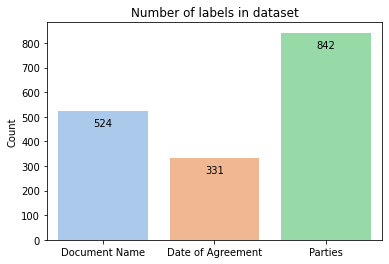

In [10]:
# Count and visualise the amount of labels

DOC_NAME_COUNT = 0
DATE_COUNT = 0
PARTIES_COUNT = 0
for index, row in df_cut.iterrows():
    for l in row['labels']:
        if l[2] == "DOC_NAME":
            DOC_NAME_COUNT += 1
        if l[2] == "AGMT_DATE":
            DATE_COUNT += 1
        if l[2] == "PARTY":
            PARTIES_COUNT += 1

# Create DataFrame for the bar plot
data=pd.DataFrame.from_dict({"Document Name":[DOC_NAME_COUNT],
                             "Date of Agreement":[DATE_COUNT],
                             "Parties":[PARTIES_COUNT]})

# Use Seaborn for the bar plot
splot = sns.barplot(palette="pastel", data=data)
splot.set(title='Number of labels in dataset', ylabel='Count')

# Annotate the bars with the count of labels
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.,p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
# Show plot
plt.show

print("The total number of labels in the dataset is:", DOC_NAME_COUNT+DATE_COUNT+PARTIES_COUNT)

In [11]:
# Check how the entity labels match up with the tokens
ents=[]

for start, end, label in row['labels']:
    if doc.char_span(start, end, label) != None:
        ent = doc.char_span(start, end, label)
        ents.append(ent)
    elif doc.char_span(start, end+1, label) != None:
        ent = doc.char_span(start, end+1, label)
        ents.append(ent)
    elif doc.char_span(start+1, end, label) != None:
        ent = doc.char_span(start+1, end, label)
        ents.append(ent)
    elif doc.char_span(start, end-1, label) != None:
        ent = doc.char_span(start, end-1, label)
        ents.append(ent)
doc.ents = ents
doc.ents

(the laws of the province,)

In [12]:
# Each word must be seperated for the transformer using the IOB format
# Create tags using token.ent_iob_ and add to the DataFrame
# Allow for any character misalignment between spaCy tokenization and Doccano character indices
tags_list_iob = []
for index, row in df_cut.iterrows():
    doc = row['tokens']
    ents=[]
    for start, end, label in row['labels']:
        if doc.char_span(start, end, label) != None:
            ent = doc.char_span(start, end, label)
            ents.append(ent)
        elif doc.char_span(start, end+1, label) != None:
            ent = doc.char_span(start, end+1, label)
            ents.append(ent)
        elif doc.char_span(start+1, end, label) != None:
            ent = doc.char_span(start+1, end, label)
            ents.append(ent)
        elif doc.char_span(start, end-1, label) != None:
            ent = doc.char_span(start, end-1, label)
            ents.append(ent)
        elif doc.char_span(start-1, end, label) != None:
            ent = doc.char_span(start-1, end, label)
            ents.append(ent)
    doc.ents = ents
    iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ != "O" else "O" for t in doc]
    tags_list_iob.append(iob_tags)
df_cut['tags'] = tags_list_iob

In [13]:
# Check to ensure we have all the data (all non-null)
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 0 to 348
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      314 non-null    int64 
 1   text    314 non-null    object
 2   labels  314 non-null    object
 3   tokens  314 non-null    object
 4   tags    314 non-null    object
dtypes: int64(1), object(4)
memory usage: 14.7+ KB


In [14]:
# Generate list of the IOB feature class labels from tags
all_tags = list(itertools.chain.from_iterable(tags_list_iob))

def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    unique_list.sort()
    return unique_list

feature_class_labels = unique(all_tags)
print(feature_class_labels)

['B-AGMT_DATE', 'B-DOC_NAME', 'B-PARTY', 'I-AGMT_DATE', 'I-DOC_NAME', 'I-PARTY', 'O']


In [15]:
# Generate the NER index tags for each token
df_cut['ner_tags'] = df_cut['tags'].apply(lambda x: [feature_class_labels.index(tag) for tag in x])


In [16]:
# Split tokens into a list ready for CSV
df_cut['split_tokens'] = df_cut['tokens'].apply(lambda x: [tok.text for tok in x])

# Check dataframe head
df_cut.head()

,id,text,labels,tokens,tags,ner_tags,split_tokens
0,15501,Exhibit 99.1 JOINT FILING AGREEMENT The unders...,"[[13, 35, DOC_NAME], [489, 505, AGMT_DATE], [5...","(Exhibit, 99.1, JOINT, FILING, AGREEMENT, The,...","[O, O, B-DOC_NAME, I-DOC_NAME, I-DOC_NAME, O, ...","[6, 6, 1, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[Exhibit, 99.1, JOINT, FILING, AGREEMENT, The,..."
1,15502,"[LOGO] AMENDMENT TO SECTION 2, PART B OF THE C...","[[7, 66, DOC_NAME], [166, 182, AGMT_DATE], [19...","([, LOGO, ], AMENDMENT, TO, SECTION, 2, ,, PAR...","[O, O, O, B-DOC_NAME, I-DOC_NAME, I-DOC_NAME, ...","[6, 6, 6, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[[, LOGO, ], AMENDMENT, TO, SECTION, 2, ,, PAR..."
2,15503,Exhibit 10.1 ENDORSEMENT AGREEMENT THIS ENDORS...,"[[13, 34, DOC_NAME], [40, 61, DOC_NAME], [111,...","(Exhibit, 10.1, ENDORSEMENT, AGREEMENT, THIS, ...","[O, O, B-DOC_NAME, I-DOC_NAME, O, B-DOC_NAME, ...","[6, 6, 1, 4, 6, 1, 4, 6, 6, 6, 6, 6, 6, 6, 6, ...","[Exhibit, 10.1, ENDORSEMENT, AGREEMENT, THIS, ..."
4,15505,CONFIDENTIAL PORTIONS OMITTED EXHIBIT 10.16 [L...,"[[78, 99, DOC_NAME], [105, 126, DOC_NAME], [18...","(CONFIDENTIAL, PORTIONS, OMITTED, EXHIBIT, 10....","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-DOC_...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 4, ...","[CONFIDENTIAL, PORTIONS, OMITTED, EXHIBIT, 10...."
5,15506,Exhibit 4.5 SUPPLY AGREEMENT between PROFOUND ...,"[[12, 28, DOC_NAME], [37, 58, PARTY], [63, 101...","(Exhibit, 4.5, SUPPLY, AGREEMENT, between, PRO...","[O, O, B-DOC_NAME, I-DOC_NAME, O, B-PARTY, I-P...","[6, 6, 1, 4, 6, 2, 5, 5, 5, 6, 2, 5, 5, 5, 5, ...","[Exhibit, 4.5, SUPPLY, AGREEMENT, between, PRO..."


In [17]:
# Export relevant columns only:
export_columns = ['id', 'ner_tags', 'split_tokens']
export_df = df_cut[export_columns]
export_df.to_json(DATA_FILE, orient="table", index=False)

In [18]:
# Export Feature Class Labels for use in Transformer fine tuning
with open(FEATURE_CLASS_LABELS, 'w') as f:
    json.dump(feature_class_labels, f, indent=2) 

#### The dataset is now ready for any transformer model!